In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#from yellowbrick.regressor import ResidualsPlot
RSEED = 42

In [ ]:
df = pd.read_csv("../Train.csv")

## Random Forest Regression using all features except the non numeric ones, 'ward' and 'ADM4_PCODE'

In [ ]:
# define X and y values
X = df.drop(['target', 'ward', 'ADM4_PCODE'], axis=1)
y = df["target"]

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [ ]:
# Fit model to training data
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)

# Make predictions on test set
y_pred = regr.predict(X_test)

In [ ]:
# evaluation metrics
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2: {r2_score(y_test, y_pred)}")

In [ ]:
# plot residuals
residuals = y_test - y_pred
fig,ax=plt.subplots()
sns.scatterplot(y_pred, residuals, ax=ax)
ax.set_xlabel('Predicted Values for target')
ax.set_ylabel('Residuals')
ax.plot();


## The residuals are not evenly distributed, they have some clusters. The model has to be improved. For the next model instead of all all features, we use only the most important features provided by `feature_importances_`: psa_00, car_01, pw_00, lln_01 , pg_00

In [ ]:
features = X.columns
importances = regr.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
for i in range(len(indices)-1,len(indices)-9, -1):
    print('feature: ',features[indices[i]], ', importance: ',importances[indices[i]])

# Random Forest Regression using best features only

In [ ]:
# Features : psa_00, car_01, pw_00, lln_01 
best_features = ['psa_00', 'car_01', 'pw_00', 'lln_01', 'pg_00']

#define X and y values
X = df[best_features]
y = df["target"]

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [ ]:
#X, y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)
regr_best = RandomForestRegressor(max_depth=2, random_state=0)
regr_best.fit(X_train, y_train)

y_pred = regr_best.predict(X_test)


In [ ]:
#evaluation metrics
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2: {r2_score(y_test, y_pred)}")

# Hyperparamater Tuning

In [ ]:
# Features : psa_00, car_01, pw_00, lln_01 
best_features = ['psa_00', 'car_01', 'pw_00', 'lln_01', 'pg_00']

#define X and y values
X = df[best_features]
y = df["target"]

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

In [ ]:
rf_random.best_params_

In [ ]:
rf_hp = RandomForestRegressor(**rf_random.best_params_)

rf_hp.fit(X_train, y_train)



In [ ]:
y_pred = rf_hp.predict(X_test)


In [ ]:
#evaluation metrics
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2: {r2_score(y_test, y_pred)}")

In [ ]:
residuals = y_test - y_pred
sns.scatterplot(y_pred, residuals)

## K-fold cross validation

## Log Transformation of target variable

In [ ]:
# target has one 0 value. for the log transform that row has to be removed from the data
df.query('target==0').count().target
df2 = df.drop(df[df['target'] == 0].index)

In [ ]:
# define X and y values
X = df2[best_features]  
#df2.drop(['target', 'ward', 'ADM4_PCODE'], axis=1)
y = np.log(df2["target"])

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [ ]:
# Fit model to training data
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)

# Make predictions on test set and revert log transform
y_pred = np.exp(regr.predict(X_test))
y_test = np.exp(y_test)

In [ ]:
#evaluation metrics
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2: {r2_score(y_test, y_pred)}")

In [ ]:
# plot residuals
residuals = y_test - y_pred
fig,ax=plt.subplots()
sns.scatterplot(y_pred, residuals, ax=ax)
ax.set_xlabel('Predicted Values for target')
ax.set_ylabel('Residuals')
ax.plot();

In [ ]:
sns.histplot(y)


In [ ]:
sns.histplot(df["target"])

## Sqrt transform of target variable

In [ ]:
# Features : psa_00, car_01, pw_00, lln_01 
best_features = ['psa_00', 'car_01', 'pw_00', 'lln_01', 'pg_00']

#define X and y values
X = df[best_features]
y = np.sqrt(df["target"])

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [ ]:
sns.histplot(y)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);               

In [ ]:
rf_hp = RandomForestRegressor(**rf_random.best_params_)
rf_hp.fit(X_train, y_train)
y_pred = rf_hp.predict(X_test)

In [ ]:
# Fit model to training data
#regr = RandomForestRegressor(max_depth=2, random_state=0)
#regr.fit(X_train, y_train)

# Make predictions on test set and revert sqrt transform
#y_pred = np.square(regr.predict(X_test))
#y_test = np.square(y_test)

In [ ]:
#evaluation metrics
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2: {r2_score(y_test, y_pred)}")

In [ ]:
# plot residuals
residuals = y_test - y_pred
fig,ax=plt.subplots()
sns.scatterplot(y_pred, residuals, ax=ax)
ax.set_xlabel('Predicted Values for target')
ax.set_ylabel('Residuals')
ax.plot();

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score
# Fit and evaluate model without hyperparameter tuning using cross validation and unscaled data 
sgd_classifier = SGDClassifier(random_state=RSEED)
scores = cross_val_score(sgd_classifier, X_train, y_train, cv=5, n_jobs=-1)

# Evaluation 
print('Score:', round(scores.mean(), 4))

## One new feature added to the data 'ward_type': [rural, urban]

In [ ]:
df_geo = pd.read_csv('../data/geo_df.csv')

In [ ]:
df_geo.head()

In [ ]:
ward_type = df_geo.ward_type
df = df.join(ward_type)

In [48]:
# define X and y values
X = df.drop(['target', 'ward', 'ADM4_PCODE'], axis=1)
y = df["target"]

In [49]:
X.head()

,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,...,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,lat,lon,NL,ward_type
0,1674.45058,5888.20750,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,0.031466,...,0.002848,0.007537,0.000000,0.012928,0,0,-29.682270,24.734743,0.292039,rural
1,1736.99230,6735.33812,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,0.123547,...,0.014566,0.057127,0.019092,0.004131,0,0,-29.119311,24.757737,3.207775,urban
2,2403.57591,7273.04995,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,0.022632,...,0.057560,0.010358,0.001421,0.040881,0,0,-29.142276,25.094093,0.000000,rural
3,1740.78737,5734.49046,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,0.005255,0.068909,...,0.000000,0.000669,0.000000,0.005011,0,0,-29.372052,24.942867,2.038778,rural
4,1730.51451,6657.23835,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,0.004985,0.009150,...,0.004859,0.001290,0.000673,0.017629,0,0,-29.409381,25.290165,0.000000,rural


In [50]:
# add dummy
X = pd.get_dummies(X)

In [51]:
X.head()

,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,...,pw_04,pw_05,pw_06,pw_07,pw_08,lat,lon,NL,ward_type_rural,ward_type_urban
0,1674.45058,5888.20750,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,0.031466,...,0.007537,0.000000,0.012928,0,0,-29.682270,24.734743,0.292039,1,0
1,1736.99230,6735.33812,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,0.123547,...,0.057127,0.019092,0.004131,0,0,-29.119311,24.757737,3.207775,0,1
2,2403.57591,7273.04995,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,0.022632,...,0.010358,0.001421,0.040881,0,0,-29.142276,25.094093,0.000000,1,0
3,1740.78737,5734.49046,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,0.005255,0.068909,...,0.000669,0.000000,0.005011,0,0,-29.372052,24.942867,2.038778,1,0
4,1730.51451,6657.23835,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,0.004985,0.009150,...,0.001290,0.000673,0.017629,0,0,-29.409381,25.290165,0.000000,1,0


In [77]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [78]:
# Fit model to training data
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)

# Make predictions on test set
y_pred = regr.predict(X_test)

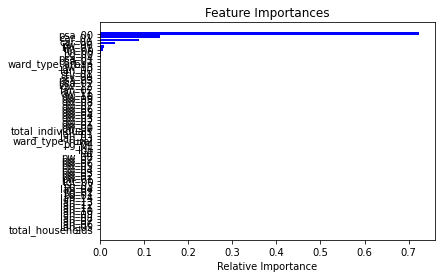

In [79]:
features = X.columns
importances = regr.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [83]:
for i in range(len(indices)-1,len(indices)-20, -1):
    print('feature: ',features[indices[i]], ', importance: ',importances[indices[i]])

feature:  psa_00 , importance:  0.723734644952695
feature:  car_01 , importance:  0.13669287018818785
feature:  car_00 , importance:  0.08732337239358927
feature:  pw_00 , importance:  0.033238678576604626
feature:  lln_01 , importance:  0.009730286567698903
feature:  lln_00 , importance:  0.005368001497876595
feature:  pg_00 , importance:  0.0022638393931644772
feature:  psa_04 , importance:  0.0010221640190117762
feature:  psa_01 , importance:  0.0006261424111715473
feature:  ward_type_urban , importance:  0.0
feature:  dw_13 , importance:  0.0
feature:  lan_00 , importance:  0.0
feature:  stv_01 , importance:  0.0
feature:  stv_00 , importance:  0.0
feature:  psa_03 , importance:  0.0
feature:  psa_02 , importance:  0.0
feature:  dw_12 , importance:  0.0
feature:  lan_02 , importance:  0.0
feature:  dw_11 , importance:  0.0
